# 1. Set up

## 1.1 Environment

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from IPython.display import display

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import sklearn
import re

import statsmodels.api as sm 
import seaborn as sns
sns.set_style('whitegrid')

from __future__ import division
from math import *
from scipy import integrate
from numpy import inf
from sklearn import mixture, neighbors 

from windrose import WindroseAxes, WindAxes

from helpers.utility_helper import *
from helpers.app_helper import *
from helpers.gmm_helper import *
from helpers.plot_helper import *
from helpers.data_reader import *

## 1.2 Read Data

In [2]:
# ipath = './data/NCDC/boscombe_down/3466726903106dat.txt'
# ipath = './data/NCDC/tiree.txt'
# ipath= "./data/NCDC/marham.txt"

# ipath= "./data/NCDC/oceania/narrandera/dat.txt" 
# ipath= "./data/NCDC/oceania/brisbane/dat.txt" 
# ipath= "./data/NCDC/oceania/brisbane_archerfield/dat.txt" 
# ipath= "./data/NCDC/oceania/auckland/4774046962787dat.txt"  

# ipath= "./data/NCDC/canada/melita_man/dat.txt" 
# ipath= "./data/NCDC/canada/fort_smith/dat.txt" 
# ipath= "./data/NCDC/canada/mildred_lake_alta/dat.txt"  # uptail wind speed 
# ipath= "./data/NCDC/canada/stony_rapids_arpt/dat.txt" # truncate data

# ipath = './data/NCDC/europe/ciampino/dat.txt' # Italy
# ipath= "./data/NCDC/europe/vatry/dat.txt"  # France, double peak?
# ipath= "./data/NCDC/europe/avord/dat.txt" # France
# ipath= "./data/NCDC/europe/huspel_aws/dat.txt"  # integer
# ipath= "./data/NCDC/europe/diepholz/dat.txt" # recent year is integer
ipath= './data/NCDC/europe/tenerife_sur/dat.txt'  # truancate speed

# ipath= "./data/NCDC/dr_ambedkar_intl/dat.txt" # India, not very good

# ipath= "./data/NCDC/south_america/senador_petronio/dat.txt" # 
# ipath= "./data/NCDC/south_america/ambrosio_lv/dat.txt" # sectors are 16
# ipath= "./data/NCDC/south_america/carlos_ibanez/dat.txt" # bad dataset, direction
# ipath= "./data/NCDC/south_america/rio_cuarto/dat.txt"  # bad dataset
# ipath= "./data/NCDC/south_america/senador_nilo/dat.txt" # bad dataset, direction 

# ipath= "./data/NCDC/wusu/dat.txt" 
# ipath= "./data/NCDC/luogang/dat.txt"  # good result
# ipath= "./data/NCDC/zhengding/dat.txt" 
# ipath= "./data/NCDC/wuxu/dat.txt" 
# ipath= "./data/NCDC/gushi/dat.txt" # data is too little
# ipath= "./data/NCDC/yueyang/dat.txt" # data is too little
# ipath= './data/NCDC/macau/8518316959352dat.txt'
# ipath= "./data/NCDC/上海/虹桥/9705626661750dat.txt"
# ipath= "./data/NCDC/南京lukou/7271776959346dat.txt"
# ipath= "./data/NCDC/武汉tianhe/5855286959350dat.txt"
# ipath= "./data/NCDC/长沙huanghua/8169756959349dat.txt"
# ipath= "./data/NCDC/郑州xinzheng/7934376661728dat.txt"

## US dataset, is mostly over a threshold, low wind speed is not complete
# ipath= "./data/NCDC/sacramento_arp/dat.txt"  # truancate data
# ipath= "./data/NCDC/st_louis_arp/9511346969491dat.txt"  truncate
# ipath= './data/NCDC/huron/3461896967321dat.txt'
# ipath= "./data/NCDC/baltimore/9963956959409dat.txt"
# ipath= './data/NCDC/kennedy/5807936958436dat.txt'
# ipath= './data/NCDC/newark/8455636958433dat.txt'
# ipath= './data/NCDC/la_guardia/1057036958434dat.txt'
# ipath= "./data/NCDC/olympia_airport/2647036962786dat.txt" # turancate speed
# ipath= "./data/NCDC/sidney/6062326959357dat.txt" 

# ipath= "./data/cn_database/beijing.txt"
# ipath= "./data/cn_database/xiamen.txt"
# ipath= "./data/cn_database/hefei.txt"
# ipath= "./data/cn_database/lasa.txt"
# ipath= "./data/cn_database/lenghu.txt"

uipath = unicode(ipath , "utf8")
cn_database = False

if not "cn_database" in ipath: 
    df = pd.read_csv(uipath,header=0, skipinitialspace=True)
    df.rename(columns={'Date':'date','Dir':'dir','Spd':'speed','Type':'type'}, inplace=True)
    df = df[['date','HrMn','type','dir','speed' ]]
else:
    df = read_cn_database(uipath)
    cn_database = True

In [3]:
# select year 1945-2014, dir < 999, speed<999
df = df.query("(dir < 999) & (speed < 999) & \
              (date >= 19800000) & (date < 20160000) & \
              (HrMn % 5 == 0 )")

# Turn dir into [0,360), some station are[10,360],some are [0,350]
df.index= df['date']
df['dir'] = df['dir'].apply(lambda x: x%360)
df.describe()

,date,HrMn,dir,speed
count,404487.000000,404487.000000,404487.000000,404487.000000
mean,20005618.063181,1195.783709,103.233056,5.893307
std,97473.549765,682.258971,83.620120,3.014626
min,19800701.000000,0.000000,0.000000,0.000000
25%,19911217.000000,600.000000,50.000000,3.600000
50%,20021203.000000,1230.000000,70.000000,5.100000
75%,20090708.000000,1800.000000,110.000000,8.200000
max,20151231.000000,2350.000000,350.000000,44.300000


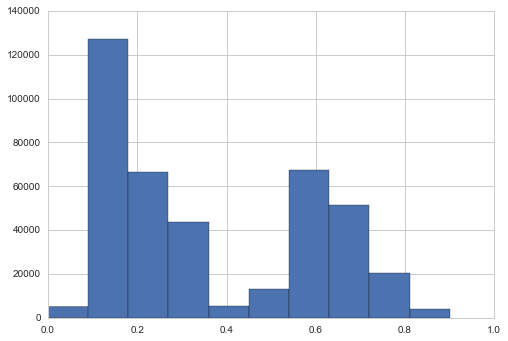

In [4]:
# Detect data stored in knot or m/s
df['decimal'] = df.speed % 1 
df.decimal.hist()
knot_unit = True if len(df.query('decimal >= 0.2'))/len(df) > 0.3 else False

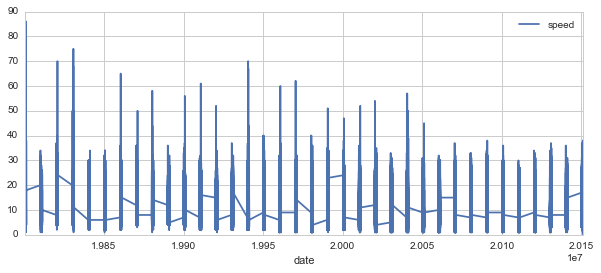

In [5]:
# Using speed unit in knot instead of m/s
# need more elaboration, some is not near an integer
if knot_unit:
    df.rename(columns={'speed':'speed_mps'}, inplace=True)
    df['speed']=df['speed_mps']
    df['speed']=df['speed_mps']*1.943845
    df['speed']=df['speed'].apply(lambda x: int(round(x)))

df['speed'].plot(legend=True,figsize=(10,4), grid=True)

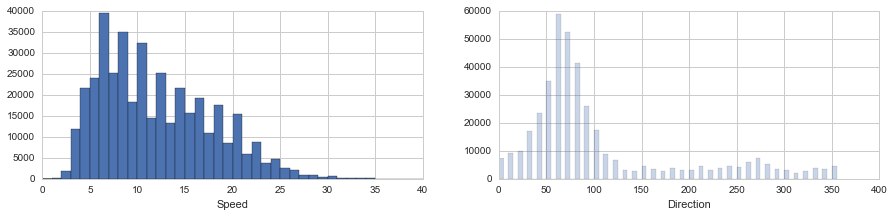

In [6]:
# Notice the gap of the distributions, so futher process needed, as below
plot_speed_and_angle_distribution(df)

## 1.3 Data Wrangling

### 1.3.1 Artefacts handling

,date,HrMn,type,dir,speed_mps,decimal,speed,incre,incre_reverse
date,,,,,,,,,
19801001,19801001,600,FM-12,200,44.3,0.3,86,70,80
19830820,19830820,600,FM-12,290,38.6,0.6,75,55,55
19820805,19820805,1200,FM-12,250,36.0,0.0,70,54,43
19830622,19830622,600,FM-12,290,36.0,0.0,70,54,64
19940603,19940603,1230,FM-16,70,36.0,0.0,70,40,43
19830729,19830729,1800,FM-12,10,35.0,0.0,68,48,62
19940710,19940710,1530,FM-15,220,34.5,0.5,67,47,56
19860528,19860528,900,SY-MT,60,33.4,0.4,65,39,39
19970406,19970406,600,SY-MT,270,31.9,0.9,62,48,51


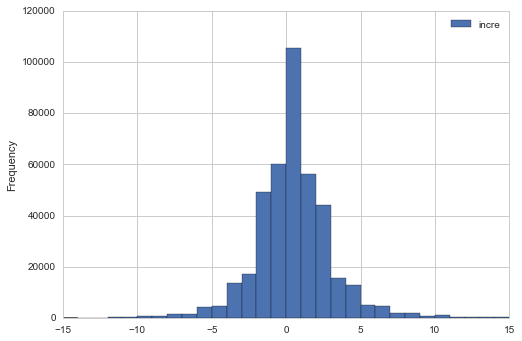

In [7]:
df['incre'] = df.speed.diff(1)
df['incre'].fillna(0)
df['incre_reverse'] = df.speed.diff(-1)
df['incre_reverse'].fillna(0)
display(df.sort_values(by='speed',ascending=False).head(10))
bins=np.arange(-15, 15 + 1, 1)
df['incre'].plot(kind='hist', bins=bins, legend=True)

In [8]:
# Simple Artefacts Handling
incre_threshold = 20 if knot_unit else 10
df = df.query('(incre < @incre_threshold )&(incre_reverse < @incre_threshold )')
df = df.query('dir % 10 <= 0.1')

After Simple Aretefacts Handling

In [9]:
# Check the max speed
df.sort_values(by='speed',ascending=False).head(10)

,date,HrMn,type,dir,speed_mps,decimal,speed,incre,incre_reverse
date,,,,,,,,,
20000721,20000721,1500,FM-15,90,24.0,0.0,47,0,4
20000721,20000721,1400,FM-15,90,24.0,0.0,47,14,0
20051128,20051128,2130,FM-15,280,23.1,0.1,45,4,1
20051128,20051128,2200,FM-15,290,22.6,0.6,44,-1,5
20051128,20051128,2000,FM-15,270,21.1,0.1,41,4,-4
20051128,20051128,2330,FM-15,300,21.1,0.1,41,7,13
19950226,19950226,1430,FM-15,70,20.6,0.6,40,1,6
19980311,19980311,2030,FM-15,70,20.6,0.6,40,5,6
19950221,19950221,2230,FM-15,60,20.6,0.6,40,5,4


### 1.3.2 Sampling Time Selection

In [10]:
df['HrMn'].value_counts().sort_index()

0       7882
10         1
15         1
20         1
30      8254
40         3
50         2
100     7470
105        1
110        3
115        1
130     8124
135        1
140        2
145        2
200     7311
205        2
210        3
215        1
220        2
225        1
230     7908
235        1
240        1
300     7542
305        2
320        4
330     7930
335        1
340        2
        ... 
1850       1
1900    8672
1915       1
1930    9139
1935       2
1940       1
2000    8235
2030    8798
2040       1
2045       1
2050       2
2100    8285
2105       1
2110       1
2115       2
2130    8691
2135       1
2140       2
2155       1
2200    7897
2210       1
2215       2
2230    8400
2235       1
2240       3
2250       1
2300    7866
2330    8384
2335       1
2350       1
Name: HrMn, dtype: int64

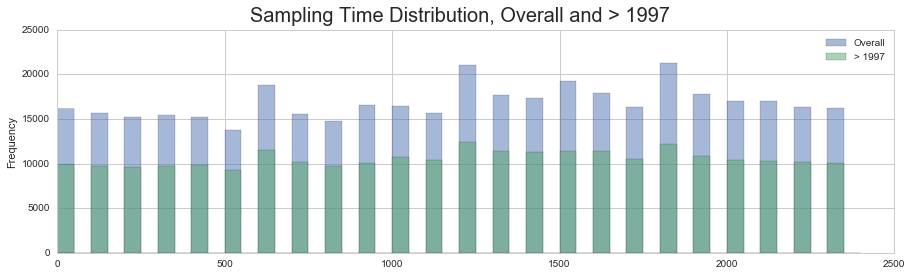

In [11]:
# Ensure data sampled equally
mid_year = int(((min(df.date)+max(df.date))/2 )/10000)
bins=np.arange(min(df.HrMn), max(df.HrMn) + 100, 50)

df['HrMn'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='Overall')

df.query('date > @mid_year * 10000')['HrMn'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='> %s' %  mid_year )

plt.suptitle('Sampling Time Distribution, Overall and > %s ' %  mid_year, fontsize = 20)
plt.legend()

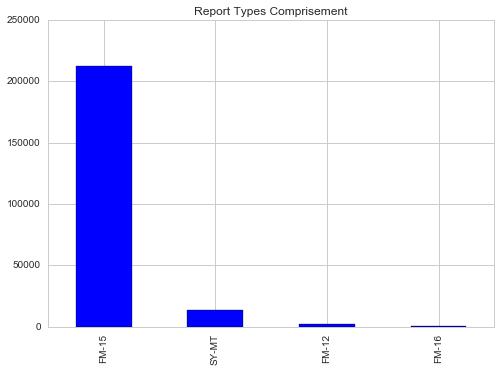

In [12]:
df.query("date >= 20000000 ")['type'].value_counts().plot(
    kind = 'bar', title = 'Report Types Comprisement')

report_type_most_used = df.query("date >= 20000000 ")['type'].value_counts().argmax()

In [13]:
# Data Selection
if "ciampino" in ipath: 
    df = df[(df['HrMn'] % 100 == 15)|(df['HrMn'] % 100 == 45)|(df['HrMn'] % 100 == 20)|(df['HrMn'] % 100 == 50)]
else: 
    df = df.query('HrMn % 5 <= 0.1')

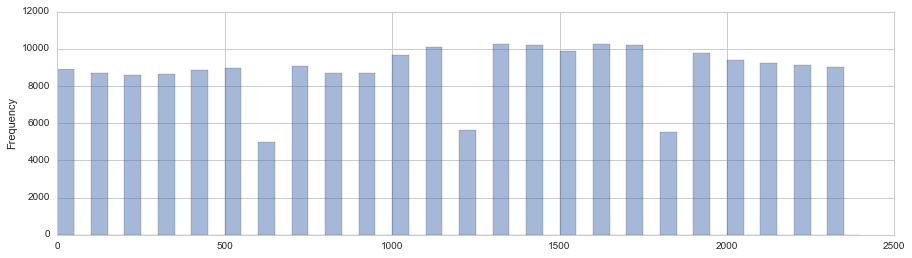

In [14]:
# We're gonna use the most frequent report type, here is its distirbution
df = df.query("type==@report_type_most_used")

df.query('date > 20000000')['HrMn'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins)

## 1.3.3 Time Shift Comparison

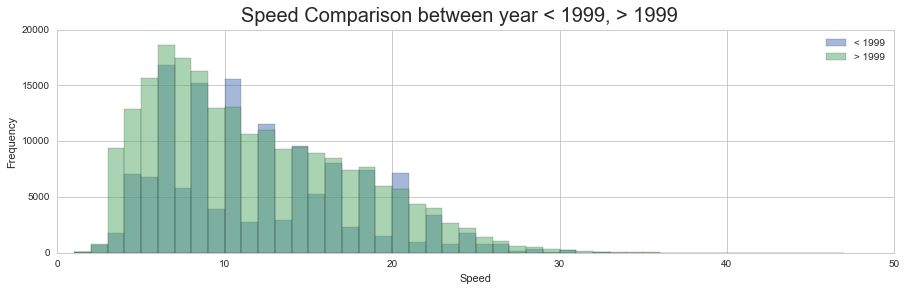

In [15]:
mid_year = int(((min(df.date)+max(df.date))/2 )/10000)

# Comparison between mid_year, looking for: 
# 1. Odd Even Bias
# 2. Time Shift of Wind Speed Distribution
bins = np.arange(min(df.speed), max(df.speed) + 1, 1)
df[df['date'] < mid_year * 10000]['speed'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='< %s' % mid_year)

df[df['date'] > mid_year * 10000]['speed'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='> %s' % mid_year)

plt.xlabel("Speed")
plt.suptitle('Speed Comparison between year < %s, > %s ' % (mid_year, mid_year), fontsize = 20)
plt.legend()

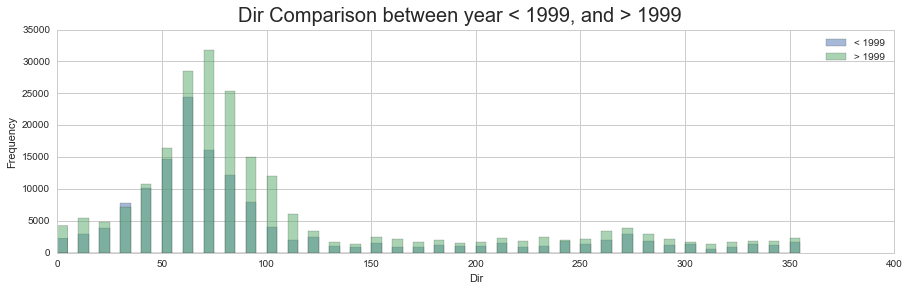

In [16]:
bins=np.arange(min(df.dir), max(df.dir) + 10, 5)
df[df['date'] < mid_year * 10000]['dir'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='< %s' % mid_year)

df[df['date'] > mid_year * 10000]['dir'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='> %s' % mid_year)

plt.xlabel("Dir")
plt.suptitle('Dir Comparison between year < %s, and > %s ' % (mid_year, mid_year), fontsize = 20)
plt.legend()

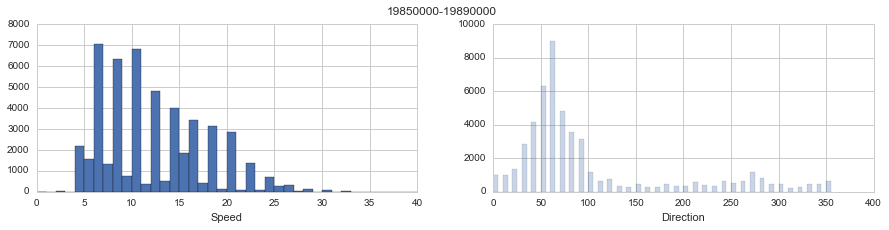

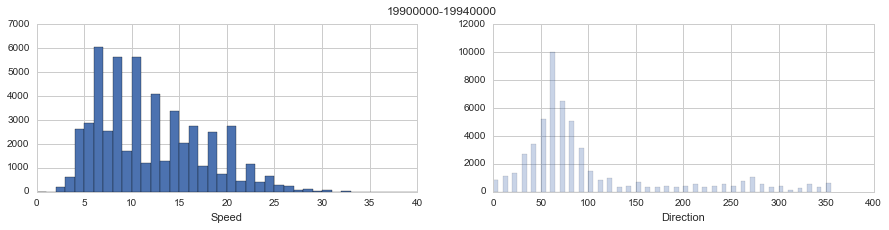

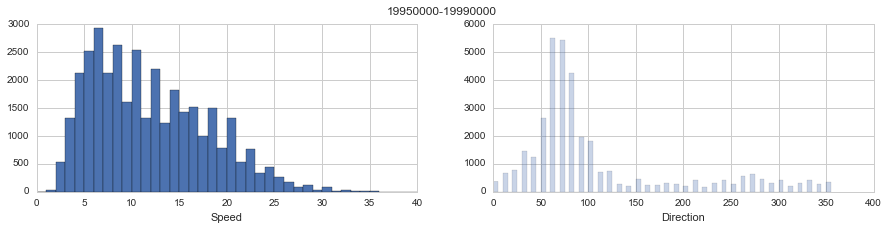

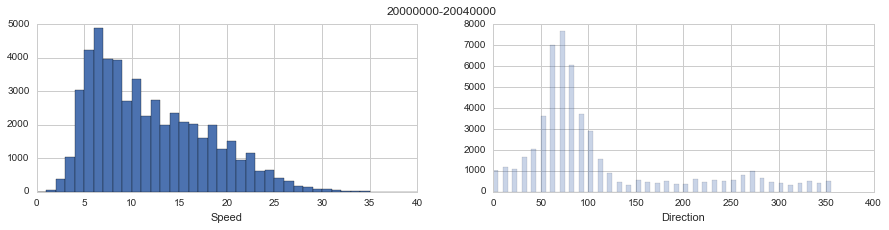

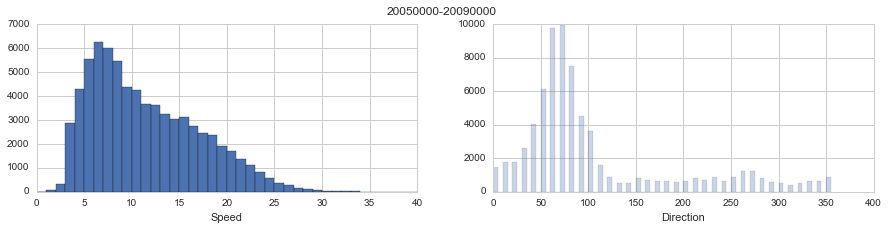

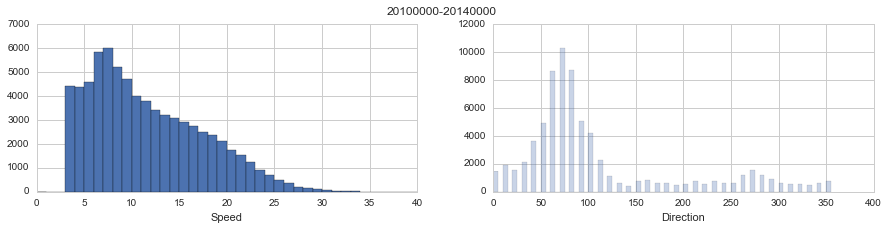

In [17]:
# Inspect the time shift of speed and degree distribution, and odd-even bias
def check_time_shift(df):
    for start_time in xrange(19850000, 20150000, 50000):
        end_time = start_time + 50000 
        sub_df = df.query('(date >= @start_time) & (date < @end_time)')
        if len(sub_df) > 0 :
            title = str(start_time) +'-' + str(end_time-10000)
            plot_speed_and_angle_distribution(sub_df, title)
        
check_time_shift(df)

## 1.4 Re-select data, data conversion, and overview of the clean dataset

In [18]:
# Year range, Reports Type, Sampling Time
df = df.query('(date >= 20100000) & (date < 20150000)')
df.describe()

,date,HrMn,dir,speed_mps,decimal,speed,incre,incre_reverse
count,72980.000000,72980.000000,72980.000000,72980.000000,72980.000000,72980.000000,72980.000000,72980.000000
mean,20120845.586503,1185.153330,107.227597,5.701184,0.417558,11.081200,-0.022650,-0.026377
std,14181.849380,690.393264,84.063068,3.045784,0.260059,5.919942,2.343118,2.348092
min,20100101.000000,0.000000,0.000000,1.000000,0.000000,2.000000,-21.000000,-21.000000
25%,20110405.000000,600.000000,60.000000,3.100000,0.100000,6.000000,-1.000000,-1.000000
50%,20120706.000000,1230.000000,80.000000,5.100000,0.500000,10.000000,0.000000,0.000000
75%,20131016.000000,1730.000000,110.000000,7.700000,0.600000,15.000000,1.000000,1.000000
max,20141231.000000,2330.000000,350.000000,19.000000,0.900000,37.000000,19.000000,16.000000


### 1.4.1 Overview

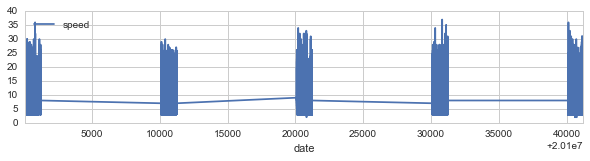

In [19]:
df['speed'].plot(legend=True,figsize=(10,2), grid=True)

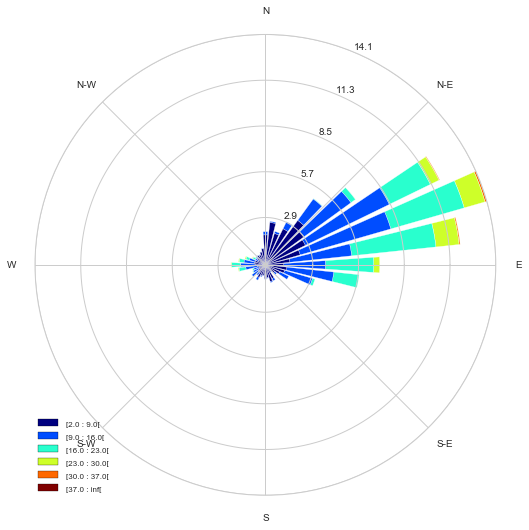

In [20]:
df.dir_windrose = df.dir
# 90 degree is in east
ax = WindroseAxes.from_ax()
ax.bar(df.dir_windrose, df.speed, normed=True, opening=0.8, edgecolor='white', nsector=36)
ax.set_legend()

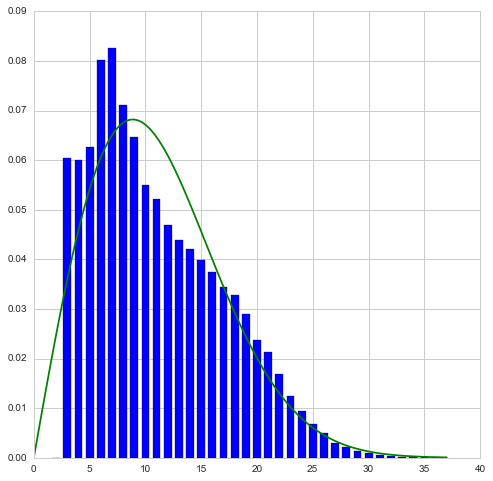

In [21]:
ax = WindAxes.from_ax()
bins=np.arange(min(df.speed), max(df.speed) + 1, 1)
ax, params = ax.pdf(df.speed, bins = bins)

In [22]:
print params
weibull_params = sp.stats.exponweib.fit(df.speed, floc=0, f0=1)
print weibull_params

(1, 1.9964213077079254, 0, 12.558408735853424)
(1, 1.9964213077079254, 0, 12.558408735853424)


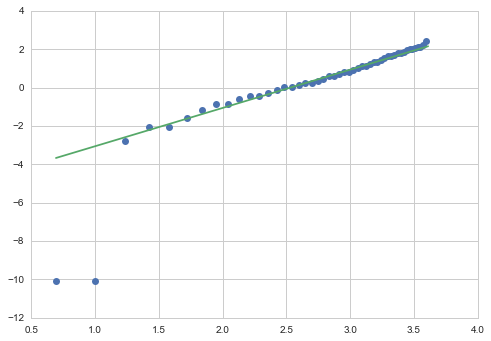

In [23]:
sample = df.speed
ecdf = sm.distributions.ECDF(sample)

x = np.linspace(min(sample), max(sample))
y = ecdf(x)
plt.plot(np.log(x), np.log(-np.log(1-y)),'o')

w_scale, c_shape = weibull_params[1], weibull_params[3]
qz=np.exp(-(x/c_shape)**w_scale)
plt.plot(np.log(x), np.log(-np.log(qz)),'-')
plt.show()

### 1.4.2 Direction Conversion, from windrose to polar system
e.g. 0 degree = north, clockwise => 90 degree = north, counterclockwise

In [24]:
df['dir'] = df['dir'].apply(lambda x: (90 - x)%360)

In [25]:
df['dir'].value_counts().sort_index()

0       5099
10      8732
20     10273
30      8643
40      4964
50      3654
60      2143
70      1551
80      1949
90      1480
100      747
110      615
120      518
130      547
140      556
150      659
160      950
170     1207
180     1538
190     1218
200      610
210      640
220      757
230      573
240      760
250      557
260      493
270      640
280      603
290      823
300      790
310      410
320      624
330     1156
340     2299
350     4202
Name: dir, dtype: int64

In [26]:
effective_coloumn = df['dir'].value_counts()[df['dir'].value_counts() > 30].sort_index()

if len(effective_coloumn) == 16:
    # For some dataset, the angle is not evenly distributed, so there is a need to redistribute
    original_angle = list(effective_coloumn.sort_index().index)
    redistributed_angle = np.linspace(0,360,num=17)[:-1]
    df['dir'].replace(to_replace=original_angle, value=redistributed_angle, inplace=True)
    display(df['dir'].value_counts().sort_index())

In [27]:
df.describe()

,date,HrMn,dir,speed_mps,decimal,speed,incre,incre_reverse
count,72980.000000,72980.000000,72980.000000,72980.000000,72980.000000,72980.000000,72980.000000,72980.000000
mean,20120845.586503,1185.153330,103.587969,5.701184,0.417558,11.081200,-0.022650,-0.026377
std,14181.849380,690.393264,115.424183,3.045784,0.260059,5.919942,2.343118,2.348092
min,20100101.000000,0.000000,0.000000,1.000000,0.000000,2.000000,-21.000000,-21.000000
25%,20110405.000000,600.000000,20.000000,3.100000,0.100000,6.000000,-1.000000,-1.000000
50%,20120706.000000,1230.000000,40.000000,5.100000,0.500000,10.000000,0.000000,0.000000
75%,20131016.000000,1730.000000,180.000000,7.700000,0.600000,15.000000,1.000000,1.000000
max,20141231.000000,2330.000000,350.000000,19.000000,0.900000,37.000000,19.000000,16.000000


### 1.4.3 Re-distribute Direction, within each sector (optional)
e.g. Dir 50 -> -45 ~ 55, to make KDE result better

In [28]:
sector_length = 360/len(effective_coloumn)
print len(effective_coloumn), sector_length

def randomize_angle(df, sector_length = 10):
    df['dir_ran'] = df['dir'].apply(lambda x: (x + np.random.uniform(-sector_length/2,sector_length/2))% 360)

    bins=np.arange(0, 360+10, 5)
    df['dir'].hist(bins=bins, alpha=0.5,figsize=(15, 6))
    bins=np.arange(0, 360+10, 1)
    df['dir_ran'].hist(bins=bins, alpha=0.5,figsize=(15, 6))
    
    df['dir']=df['dir_ran']
    df.drop(['dir_ran'], 1,inplace=True)
    return df

36 10.0


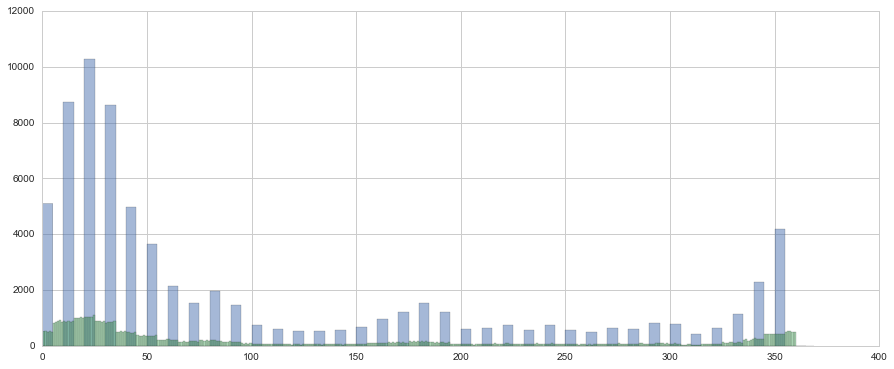

In [29]:
# Randomize the angle degree, to form a better KDE estimation
df['dir_int'] = df['dir']
df = randomize_angle(df, sector_length)

In [30]:
def randomize_speed(df):
    # Round down speed, need more caution
    df['speed_ran'] = df['speed'].apply(lambda x: (x + np.random.uniform(-1,0)) if x > 0 else x)

    bins=np.arange(0, df.speed.max(), 1)
    df['speed'].hist(bins=bins, alpha=0.5,figsize=(15, 6))
    bins=np.arange(0, df.speed.max(), 0.5)
    df['speed_ran'].hist(bins=bins, alpha=0.5,figsize=(15, 6))
    
    df['speed']=df['speed_ran']
    df.drop(['speed_ran'], 1,inplace=True)
    return df

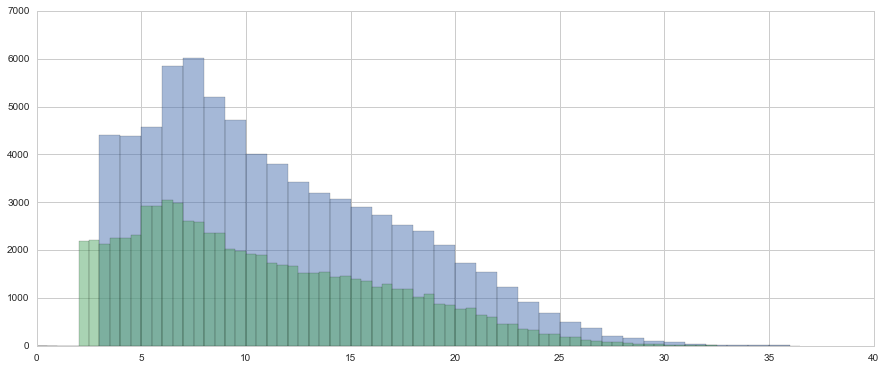

In [31]:
# Each original cell is split between the value, # so the peak is shift left
# e.g. 2 -> (1.5,2), (2,2.5); or 3 -> (2,3)
df['speed_int'] = df['speed']
df = randomize_speed(df)

### 1.4.4 Generate (x,y) from (speed,dir)

6.73921162655 2.32045480187


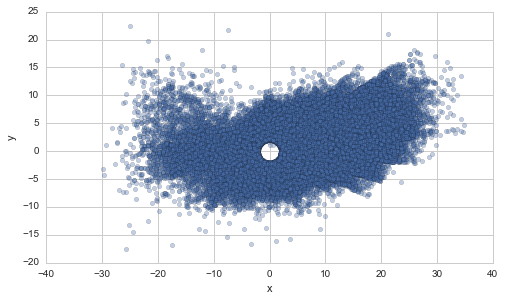

In [32]:
df['x'] = df['speed'] * np.cos(df['dir'] * np.pi / 180.0)
df['y'] = df['speed'] * np.sin(df['dir'] * np.pi / 180.0)
fig, ax = plt.subplots(figsize=(8, 8), dpi=80)
ax.set_aspect('equal')
df.plot(kind='scatter', x='x', y='y', alpha=0.35, ax=ax)
print np.mean(df.x), np.mean(df.y)

# 2. Create input data, i.e. speed_set

In [33]:
# speed_set = np.array(zip(-df.x, -df.y)) # Adjust the direction to match for Cook's paper
speed_set = np.array(zip(df.x, df.y))
speed_angle_set = np.array(zip(df.speed, df.dir))
max_speed = df.speed.max()
number_of_gaussian = 3

In [34]:
fitting_range = []
if knot_unit == True:
    fitting_axis_range = np.arange(-20, 21, 1)
    plot_axis_range = np.arange(-25, 25, 1)
else:
    fitting_axis_range = np.arange(-10, 11, 1)
    plot_axis_range = np.arange(-10, 11, 1)
    
for i in fitting_axis_range:
    for j in fitting_axis_range:
        fitting_range.append([i,j])

original_dim = int(np.sqrt(len(fitting_range))) 

# 3. Kernel Density Estimation

In [35]:
sample = speed_set

In [36]:
# # The bandwidth value would be too radical, so we forsake this approach
# from sklearn.grid_search import GridSearchCV
# grid = GridSearchCV(neighbors.KernelDensity(),
#                     {'bandwidth': np.linspace(0.1, 1.0, 15)},
#                     n_jobs=-1, cv=4) 
# grid.fit(sample)
# print grid.best_params_
# kde = grid.best_estimator_

In [37]:
bandwidth = 1 if knot_unit else 0.5  # for wuhan, 0.4 is better
kde = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample)

points = fitting_range
# very slow if the dataset is too large, e.g. 100,000
# kde returns log prob, need to convert it
kde_result = np.exp(kde.score_samples(points))
print kde_result[:5]
print len(kde_result)

[  4.11421062e-10   6.52712585e-09   3.80950650e-08   8.18118721e-08
   6.54880244e-08]
1681


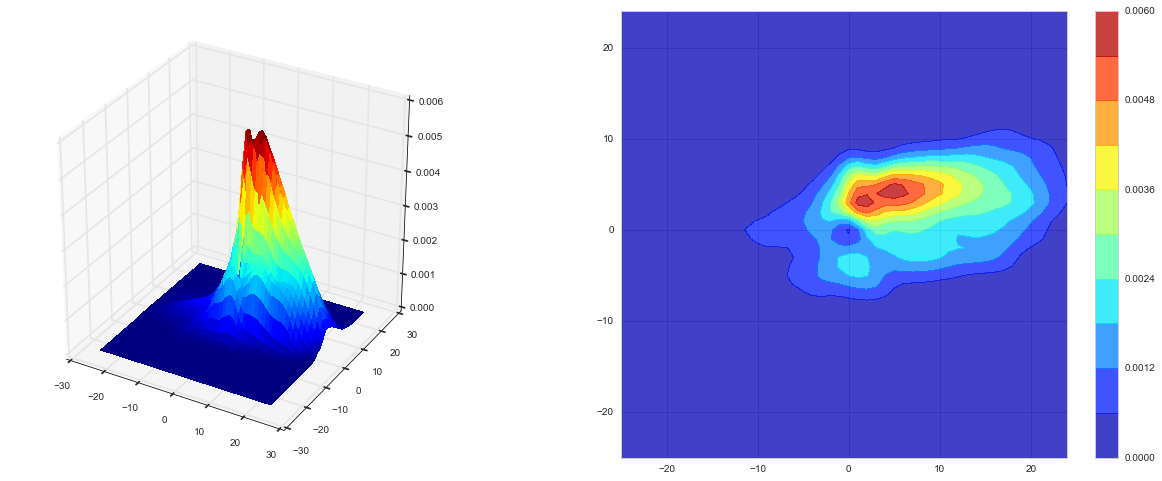

In [38]:
# Plot jPDF
X = Y = plot_axis_range
# Can't work if pass as generate_Z_from_X_Y(X,Y, np.exp(kde.score_samples())), need to use lambda
# see http://stackoverflow.com/questions/21035437/passing-a-function-as-an-argument-in-python
kde_Z = generate_Z_from_X_Y(X,Y, lambda coords: np.exp(kde.score_samples(coords)))

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,kde_Z,ax1)
ax2 = fig.add_subplot(1,2,2)
plot_2d_prob_density(X,Y,kde_Z,ax2)

In [39]:
kde_cdf = cdf_from_pdf(kde_result)

# 4. GMM Estimation, using EM algo

In [40]:
sample= speed_set
clf = mixture.GMM(n_components=number_of_gaussian, covariance_type='full')
clf.fit(sample)

clf.converged_

True

In [41]:
gmm_em_result = read_gmm_em_result(clf, print_result = False)
pretty_print_gmm(gmm_em_result)  

,weight,mean_x,mean_y,sig_x,sig_y,corr
0,0.392616,13.888339,2.548183,5.845168,4.242930,0.442912
1,0.379942,5.029437,4.398512,4.758621,2.197155,0.304196
2,0.227442,-2.745625,-1.544062,8.128151,3.991764,-0.225558


GMM Plot Result
0.392616038199 [[ 13.88833886   2.54818305]] [ 3.52802869  6.3024967 ] -63.1717508658
0.379942397979 [[ 5.02943671  4.39851214]] [ 2.06803404  4.81613958] -80.1762535244
0.227441563822 [[-2.7456248  -1.54406246]] [ 3.85845591  8.19227286] -98.1378765511


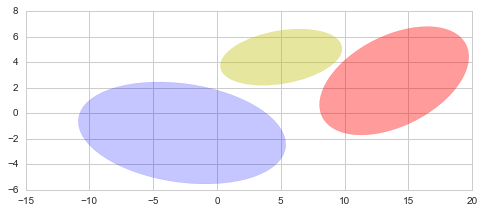

In [42]:
plot_gmm_ellipses(gmm_em_result)

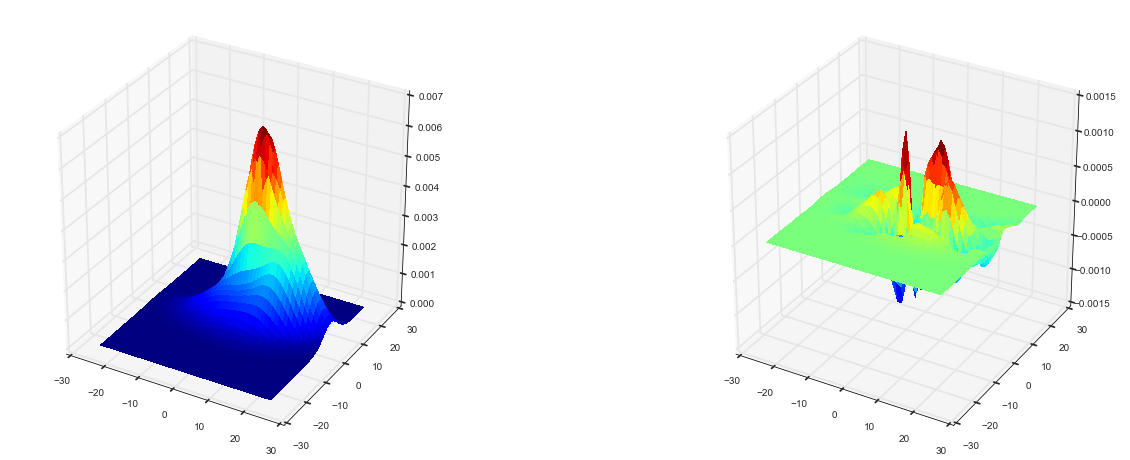

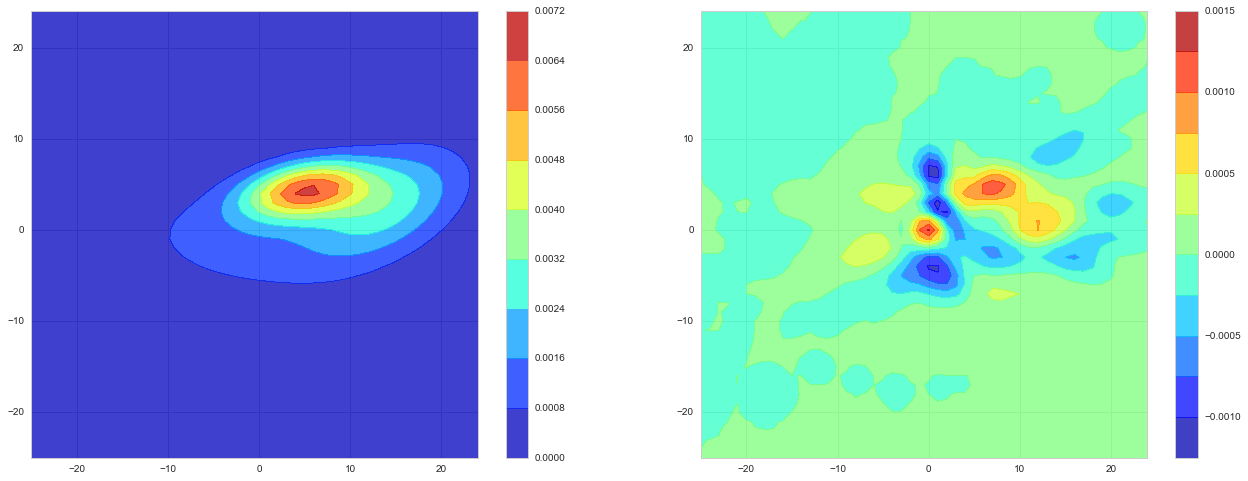

In [43]:
X = Y = plot_axis_range
pdf_Z = generate_Z_from_X_Y(X,Y, lambda coords: np.exp(clf.score_samples(coords)[0]))

def residule_between_kde_and_gmm(points):
    kde_vals = np.exp(kde.score_samples(points))
    gmm_vals = np.exp(clf.score_samples(points)[0])
    return gmm_vals - kde_vals

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2,projection = '3d')
plot_3d_prob_density(X,Y,residual_Z,ax2)
gmm_em_3d_fig = fig

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1)
plot_2d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2)
plot_2d_prob_density(X,Y,residual_Z,ax2)
gmm_em_2d_fig = fig

## GMM, EM VS. KDE

In [44]:
points = fitting_range
gmm_pdf_result = np.exp(clf.score_samples(points)[0])

In [45]:
# put into Pandas to make it looks better
pd.DataFrame([goodness_of_fit_summary(gmm_pdf_result, kde_result, count = len(df))])

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,7418.308548,0.027187,4.683030e-08,0.037911,0.384987,0.957876


# 5. Least Square Prob Estimation

In [46]:
sample = speed_set
points = fitting_range

In [47]:
gmm_em_result = read_gmm_em_result(clf, print_result = False)
pretty_print_gmm(gmm_em_result)             

,weight,mean_x,mean_y,sig_x,sig_y,corr
0,0.392616,13.888339,2.548183,5.845168,4.242930,0.442912
1,0.379942,5.029437,4.398512,4.758621,2.197155,0.304196
2,0.227442,-2.745625,-1.544062,8.128151,3.991764,-0.225558


In [48]:
count = len(df)
def GMM_fit_score(gmm, kde_result, method = 'square_error'): 
    # 1. Create the GMM PDF
    if not isinstance(gmm[0], np.ndarray):
        gmm = group_gmm_param_from_gmm_param_array(gmm, sort_group = False)
    mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
    # 2. Fit the model using different metrics
    gmm_pdf_result = mixed_model_pdf(points)
    if method == 'square_error':
        # 2.1 Square error
        error_array = np.power(gmm_pdf_result - kde_result,2)
        result = mse_log = np.log(np.average(error_array))
    elif method == 'chi_square':
        # 2.2 Chi square
        error_array = np.power(gmm_pdf_result - kde_result,2)
        # unable to * count = 43412
        result = chi_square_stat = sum(error_array/gmm_pdf_result) 
    elif method == 'K_S':
        # 2.3 K-S statistc
        gmm_cdf = cdf_from_pdf(gmm_pdf_result)
        diff = np.absolute(gmm_cdf - kde_cdf)
        result = KS_stat = np.amax(diff)
    return result

# from GMM,EM 
# GMM format: weight, meanx, meany, sigx, sigy, rho
x0 = gmm_em_result

cons = [
    # sum of every 6th element, which is the fraction of each gaussian
    {'type': 'eq', 'fun': lambda x: sum(x[::6]) - 1},
    # limit the width/height ratio of elliplse, optional
#     {'type': 'ineq', 'fun': lambda x: width_height_ratios_set(x) - 1/3},
#     {'type': 'ineq', 'fun': lambda x: 3 - width_height_ratios_set(x)},
]

bonds = [(0., 0.99),(-30, 30),(-30, 30),(0., 30),(0., 30),(-0.99, 0.99)]*int(len(x0)/6)

result = sp.optimize.minimize(
    lambda x0: GMM_fit_score(x0, kde_result),
    x0,
    bounds = bonds,
    constraints=cons,
    tol = 0.000000000001,
    options = {"maxiter": 500})
result

     fun: -17.569904392106363
     jac: array([  2.96682835e-01,   0.00000000e+00,   0.00000000e+00,
        -2.38418579e-07,  -2.38418579e-07,  -2.38418579e-07,
         2.96679735e-01,   0.00000000e+00,   0.00000000e+00,
         2.38418579e-07,   0.00000000e+00,   4.76837158e-07,
         2.96682358e-01,   0.00000000e+00,  -2.38418579e-07,
         0.00000000e+00,  -2.38418579e-07,   0.00000000e+00,
         0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 1290
     nit: 64
    njev: 64
  status: 0
 success: True
       x: array([  0.31790681,  15.02741679,   4.6949726 ,   5.77760612,
         3.4794111 ,   0.06202318,   0.37923582,   3.87441741,
         4.04937357,   4.90550276,   2.3133066 ,   0.23318727,
         0.30285737,   5.06835881,  -2.7140292 ,   9.47638946,
         2.92867338,   0.36961374])

## LRMSE VS. KDE

In [49]:
kde_result[:5]

array([  4.11421062e-10,   6.52712585e-09,   3.80950650e-08,
         8.18118721e-08,   6.54880244e-08])

In [50]:
gmm = group_gmm_param_from_gmm_param_array(result.x, sort_group = True)
mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
gmm_pdf_result = mixed_model_pdf(points)

pretty_print_gmm(gmm)

,weight,mean_x,mean_y,sig_x,sig_y,corr
0,0.379236,3.874417,4.049374,4.905503,2.313307,0.233187
1,0.317907,15.027417,4.694973,5.777606,3.479411,0.062023
2,0.302857,5.068359,-2.714029,9.476389,2.928673,0.369614


GMM Plot Result
0.379235822036 [[ 3.87441741  4.04937357]] [ 2.2325726   4.94276889] -82.1038798191
0.317906808448 [[ 15.02741679   4.6949726 ]] [ 3.46893036  5.78390494] -86.6573169912
0.302857369516 [[ 5.06835881 -2.7140292 ]] [ 2.70215899  9.54344916] -82.9122912901


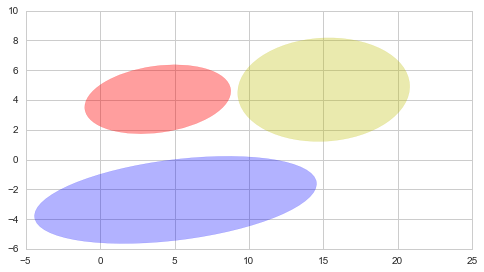

In [51]:
plot_gmm_ellipses(gmm)

## Goodness-of-fit indicators

In [52]:
pd.DataFrame(
    [goodness_of_fit_summary(gmm_pdf_result, kde_result, count = len(df))])

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,6.130261e+08,0.009147,2.341464e-08,0.026807,0.272224,0.978939


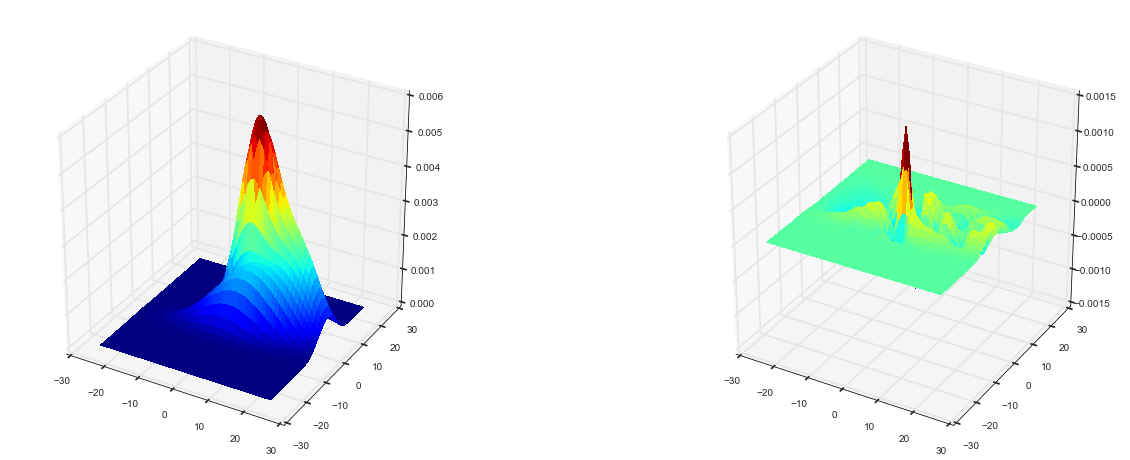

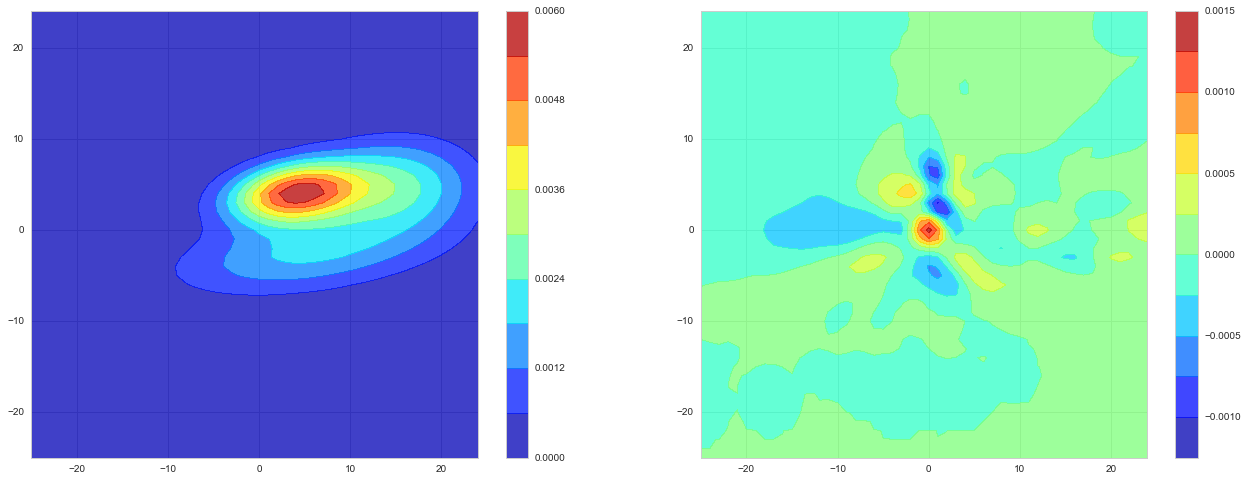

In [53]:
X = Y = plot_axis_range
pdf_Z = generate_Z_from_X_Y(X,Y, mixed_model_pdf)# passing a function as an argument

def residule_between_kde_and_gmm(points):
    kde_vals = np.exp(kde.score_samples(points))
    gmm_vals = mixed_model_pdf(points)
    return gmm_vals - kde_vals

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2,projection = '3d')
plot_3d_prob_density(X,Y,residual_Z,ax2)

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1)
plot_2d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2)
plot_2d_prob_density(X,Y,residual_Z,ax2)

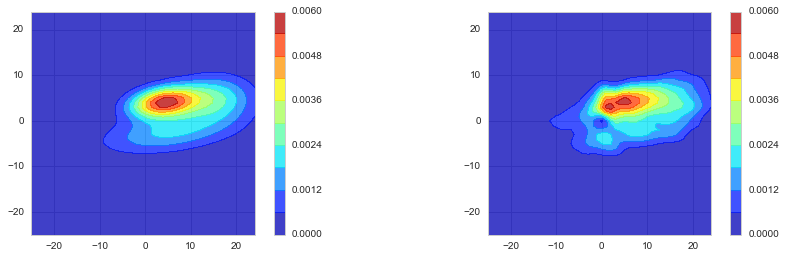

In [54]:
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(1,2,1)
plot_2d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2)
plot_2d_prob_density(X,Y,kde_Z,ax2)

In [55]:
def f(V,theta):
    return (mixed_model_pdf([[V*cos(theta),V*sin(theta)]]))*V

x_vals_OEN3_LMSE  = np.arange(0, max_speed, 0.5)
y_vals_OEN3_LMSE =[integrate.nquad(f, [[0, x_val],[0, 2*np.pi]]) for x_val in x_vals_OEN3_LMSE ]

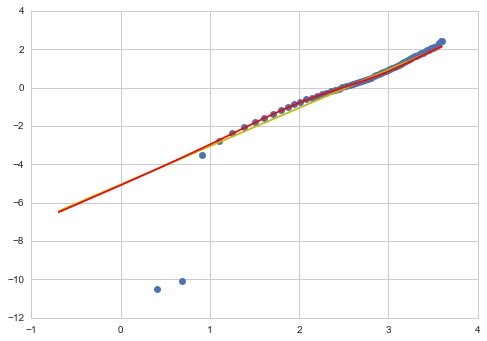

In [56]:
sample = df.speed
x = np.arange(0, max_speed, 0.5)

# 1. Plot v-p points, empirical distribution
ecdf = sm.distributions.ECDF(sample)
y = ecdf(x)
plt.plot(np.log(x), np.log(-np.log(1-y)),'o')

# 2. Weibull distribution
w_scale, c_shape = weibull_params[1], weibull_params[3]
qz=np.exp(-(x/c_shape)**w_scale)
plt.plot(np.log(x), np.log(-np.log(qz)),'-', color = 'y')

# 3. OEN3 distribution, LMSE
x, y_ = x_vals_OEN3_LMSE, y_vals_OEN3_LMSE
y = np.array(zip(*y_)[0])
plt.plot(np.log(x), np.log(-np.log(1-y)),'-', color = 'r')

plt.show()

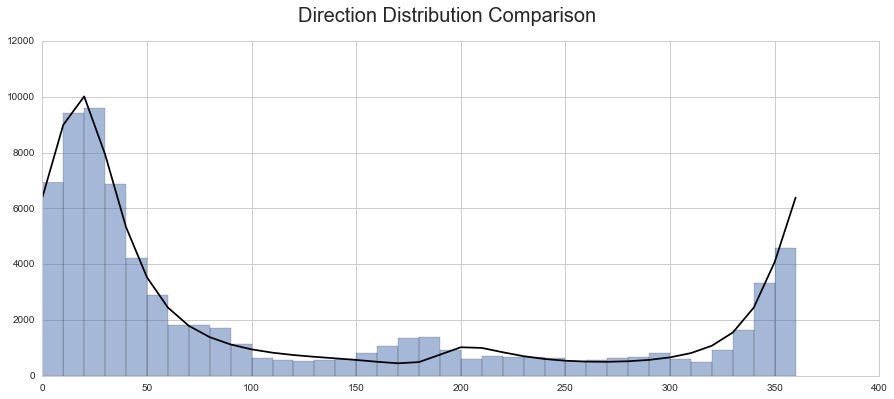

In [57]:
# Calculate Angle Distribution
x_vals = np.linspace(0,2*np.pi, num=36+1)
y_vals_ =[integrate.nquad(f, [[0, inf],[x_val-np.pi/36, x_val+np.pi/36]]) for x_val in x_vals]

# 1. integrate.nquad returns 2 vaule, result, abserr. Need to abstract the first to plot
# 2. * length of data size, to adjust the plot space
y_vals = np.array(zip(*y_vals_)[0])*len(df['dir']) 

bins=np.arange(0, 360 + 1, 10)
df['dir'].hist(bins=bins, alpha=0.5,figsize=(15, 6))

plt.plot(x_vals/np.pi*180, y_vals,'-', color='black')
plt.suptitle('Direction Distribution Comparison', fontsize = 20)
plt.show()

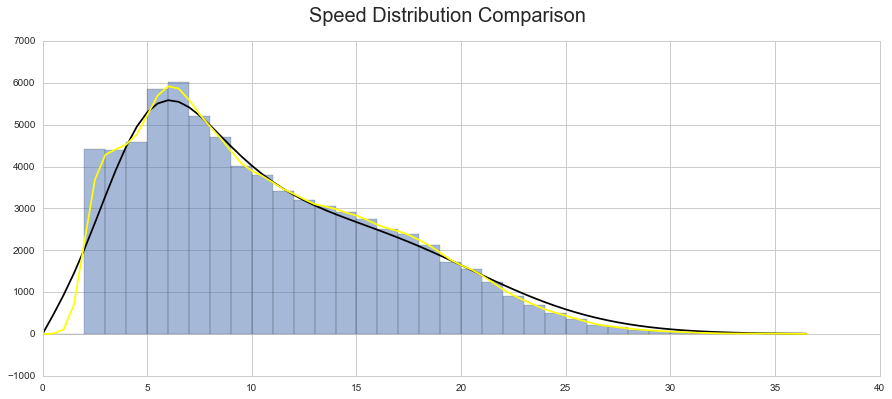

In [58]:
# Calculate Speed Distribution
# 1. GMM Model
x_vals = np.arange(0, max_speed, 0.5)
y_vals_ =[integrate.nquad(f, [[x_val-0.5, x_val+0.5],[0, 2*np.pi]]) for x_val in x_vals]
y_vals = np.array(zip(*y_vals_)[0])*len(df.speed)
plt.plot(x_vals, y_vals,'-', color='black')

# 2. Observation
bins = np.arange(0, max_speed, 1)
df['speed'].hist(bins=bins, alpha=0.5,figsize=(15, 6))

# 3. 1d KDE
sample = np.array(df.speed).reshape(-1, 1)
kde_temp = neighbors.KernelDensity(bandwidth=0.5).fit(sample) 
y_vals = [np.exp(kde_temp.score_samples(x_val))*len(sample) for x_val in x_vals]
plt.plot(x_vals, y_vals,'-', color='yellow')

plt.suptitle('Speed Distribution Comparison', fontsize = 20)
plt.show()

In [59]:
# Calculate Speed Distribution
def model_data_comparison(df, original_sector_width = 10, incre = 10):
    start, end = original_sector_width/2 + incre/2, 360 - incre/2
    max_speed = df.speed.max()
    for angle in np.arange(start, end, incre):
        angle_radian, incre_radian = radians(angle), radians(incre)  

        # Select data from observation
        start_angle, end_angle = angle-incre/2, angle+incre/2
        sub_df= df[(df['dir'] >= start_angle) & (df['dir'] <= end_angle)] 

        # 1. Count comparison
        # 1.1. Data Count
        bins = np.arange(0, max_speed, 1)
        sub_df['speed'].hist(bins=bins, alpha=0.5,figsize=(12, 2))
        
        # 1.2. Model Count
        x_vals = np.arange(0, max_speed, 0.5)
        y_vals_ =[integrate.nquad(f, 
                                  [[x_val-0.5, x_val+0.5],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
                  for x_val in x_vals]
        y_vals = np.array(zip(*y_vals_)[0])*len(df.speed)
        plt.plot(x_vals, y_vals,'-', color='black')
    
        title = str(angle) + ' (' + str(start_angle) + '-' +str(end_angle) + ')'
        plt.suptitle(title+' Degree Speed Distribution Comparison', fontsize = 15)
        plt.show()      
        
        # 2. CDF, Weibull plot comparison
        # 2.1. Data's empirical distribution
        sample = sub_df.speed
        x =np.arange(0, max(sample), 0.5)
        ecdf = sm.distributions.ECDF(sample)
        y_cdf = ecdf(x)
        
        # 2.2. Model
        y_ =[integrate.nquad(f, [[0, x_val],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
             for x_val in x]
        direction_prob = integrate.nquad(f, [[0, inf],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
        y_gmm = np.array(zip(*y_)[0])/direction_prob[0]
        
#         # 2.3.1. P-P Plot
#         p_line = np.linspace(0, 1)
#         plt.plot(y_cdf, y_gmm,'o')
#         plt.plot(p_line, p_line,'-')
#         plt.show()
        
        # 2.3.2. Plot in ordinary axis
        plt.plot(x, y_cdf,'o')
        plt.plot(x, y_gmm,'-', color = 'r')
        plt.show()
        
        # 2.3.3. Plot in Weibull axis
        plt.plot(np.log(x), np.log(-np.log(1-y_cdf)),'o')
        plt.plot(np.log(x), np.log(-np.log(1-y_gmm)),'-', color = 'r')
        plt.show()

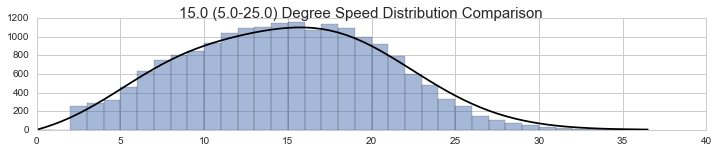

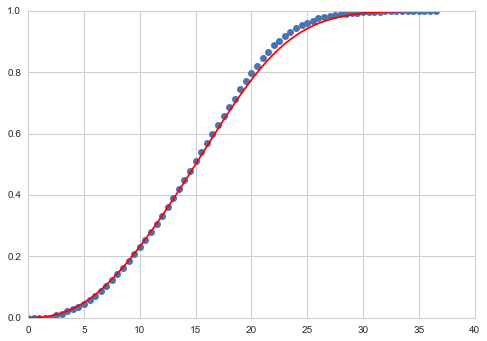

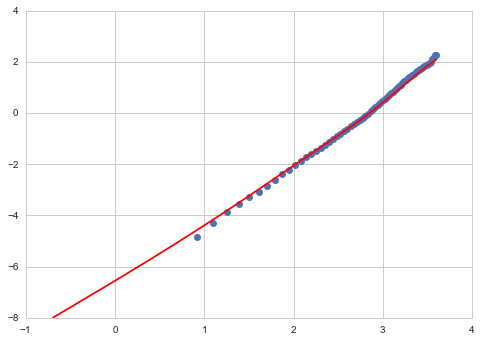

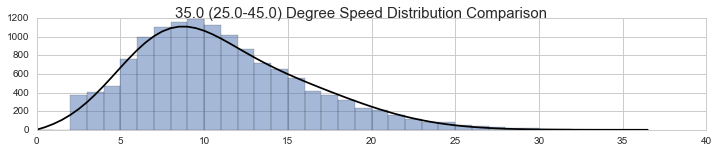

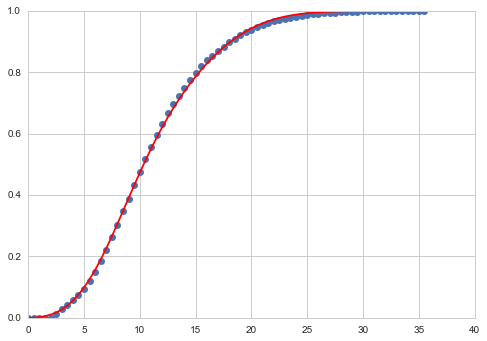

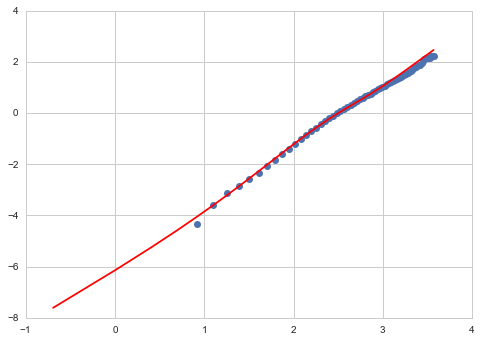

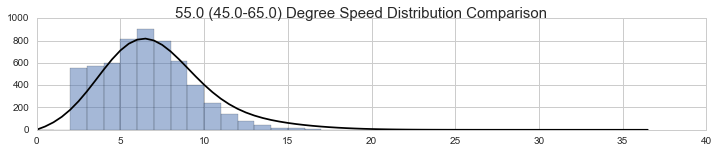

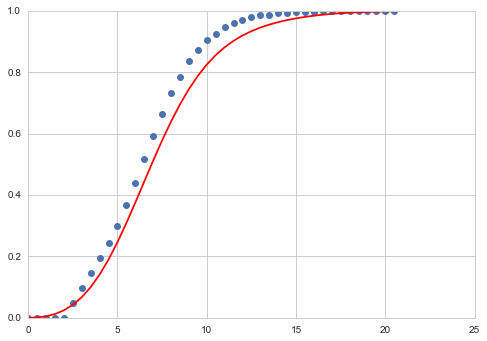

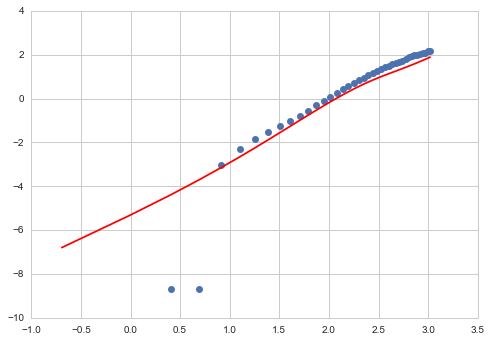

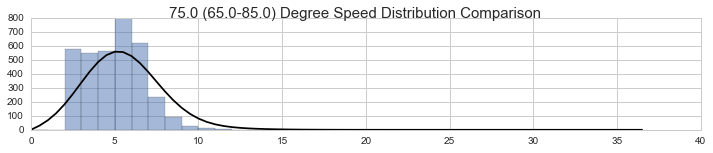

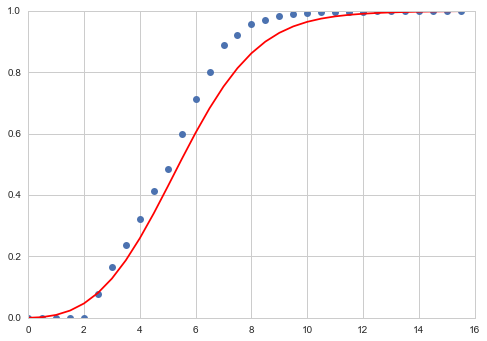

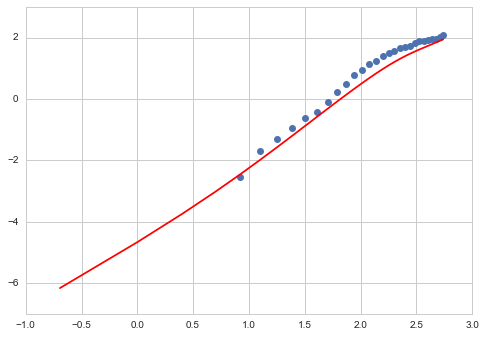

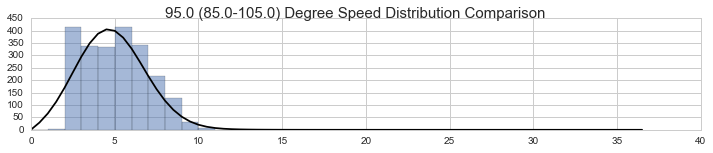

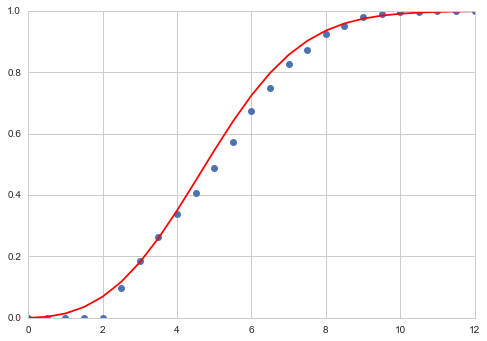

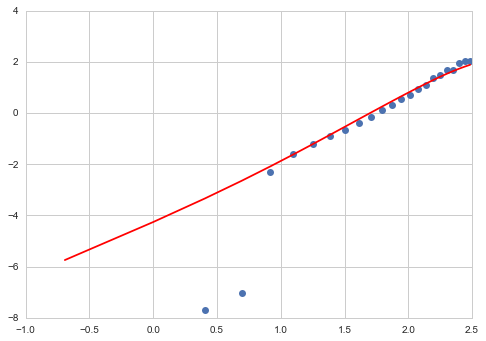

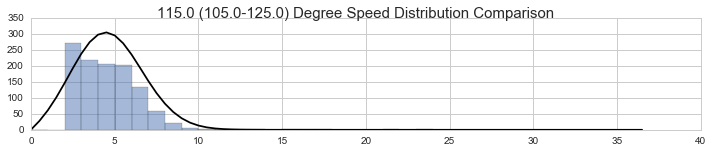

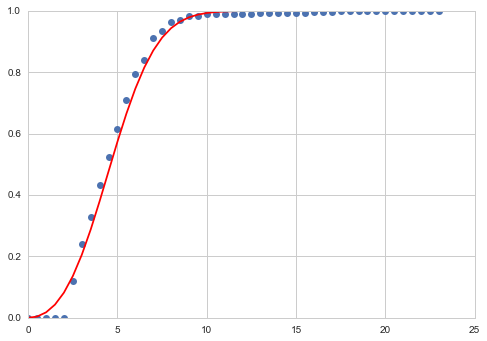

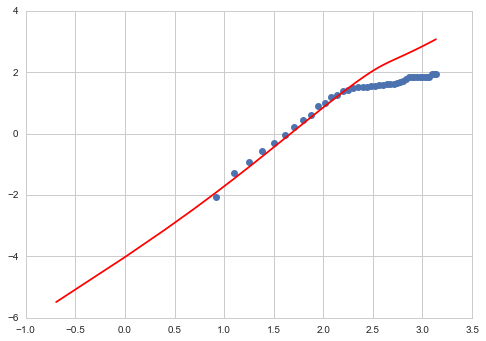

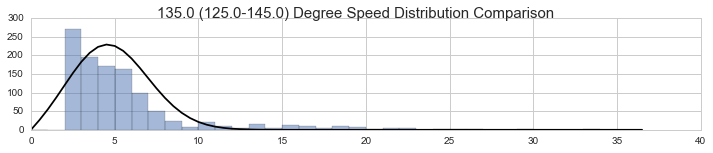

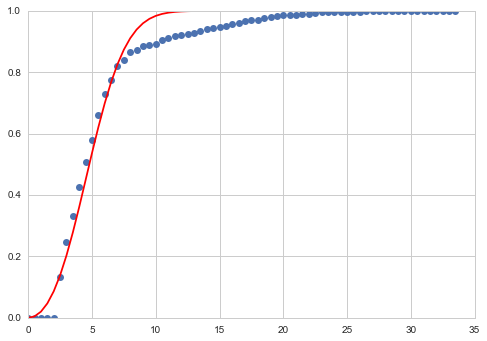

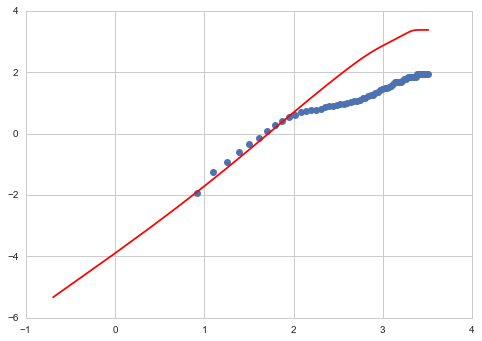

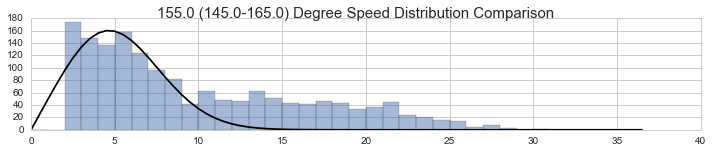

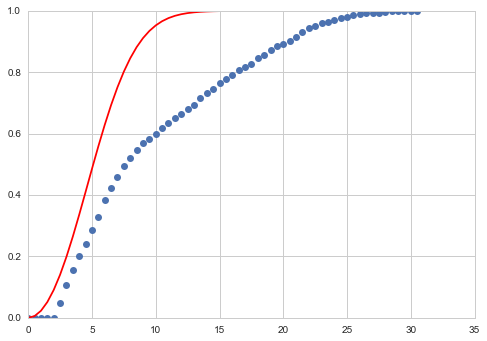

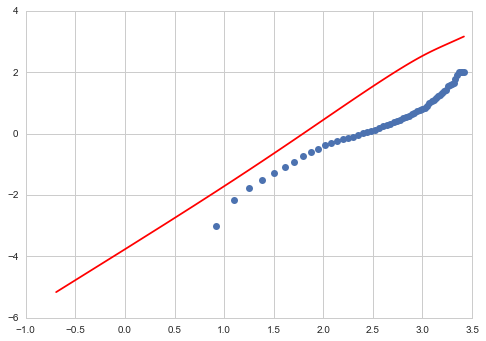

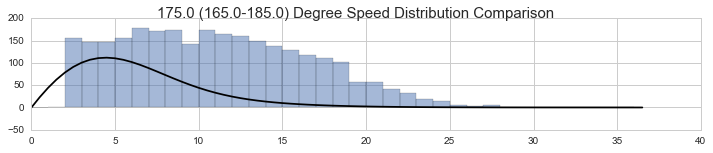

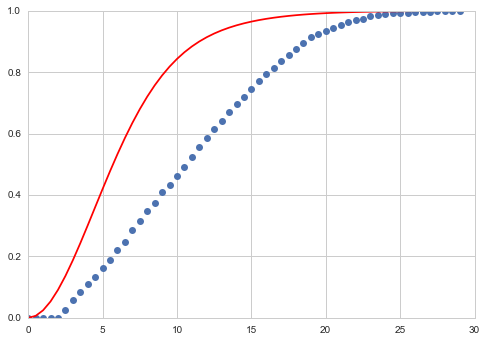

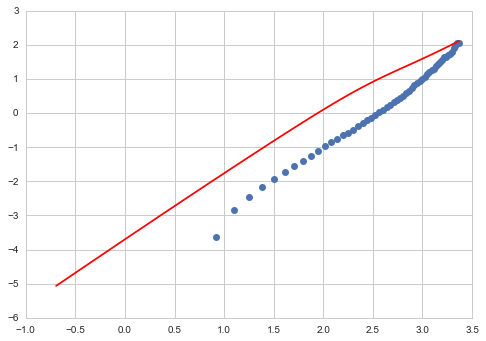

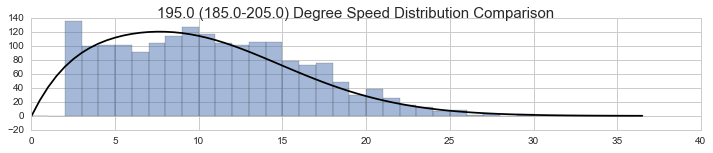

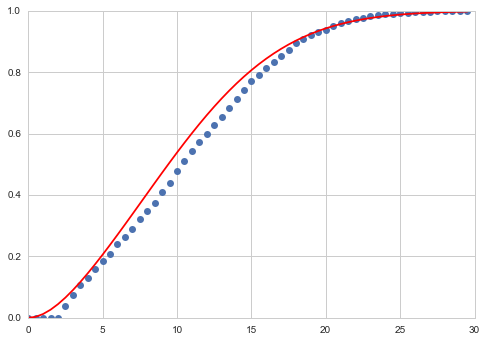

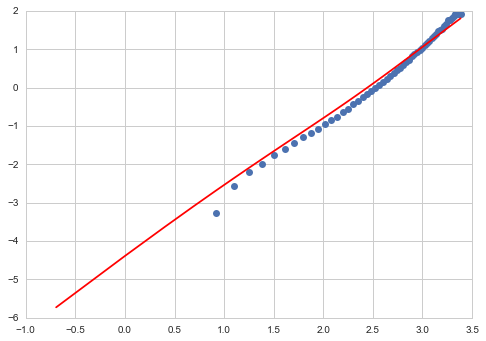

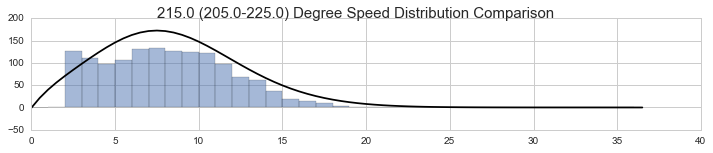

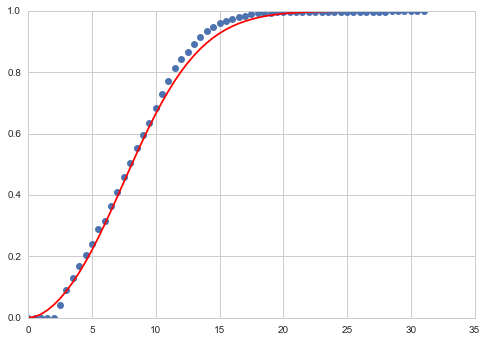

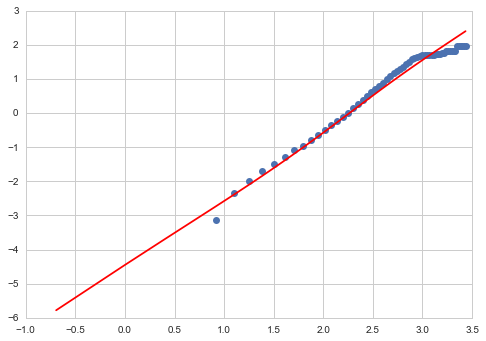

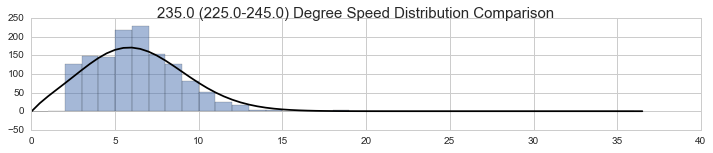

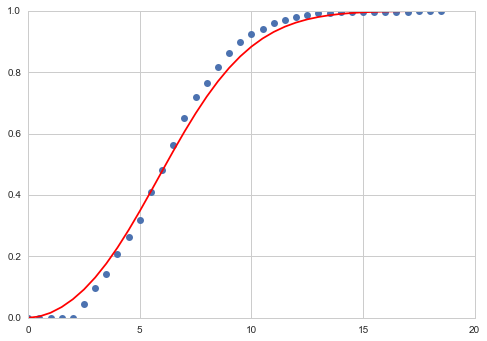

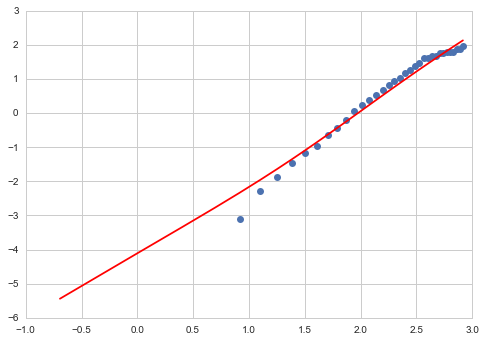

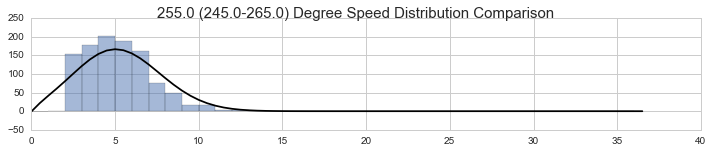

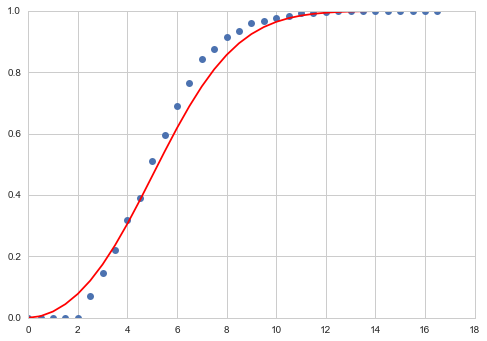

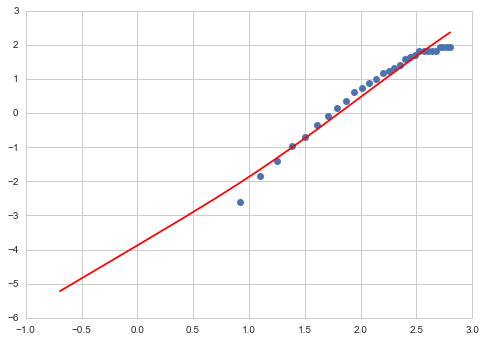

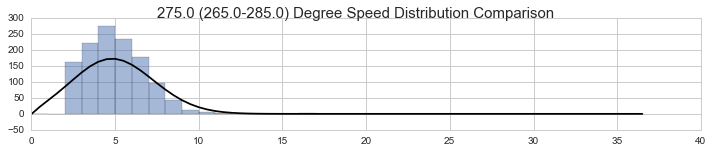

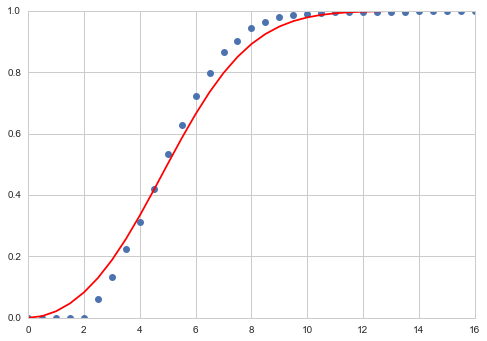

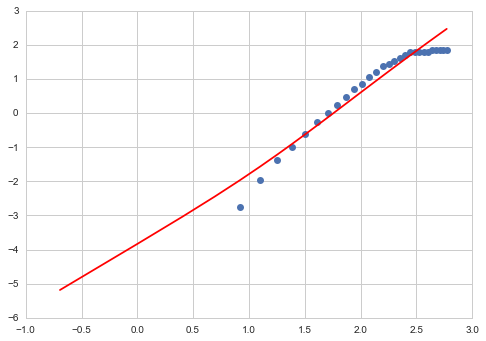

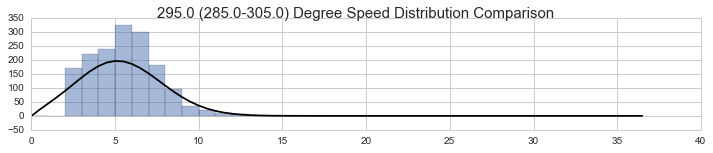

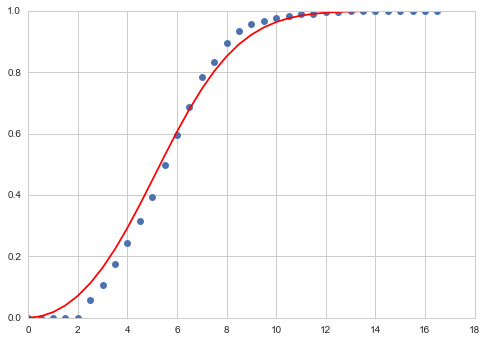

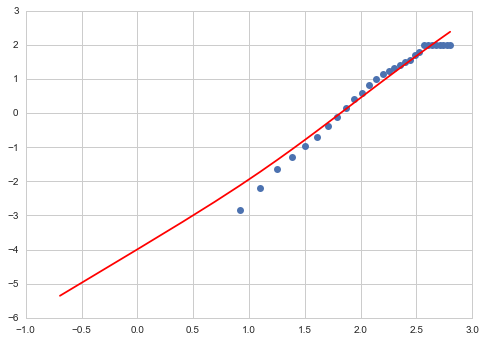

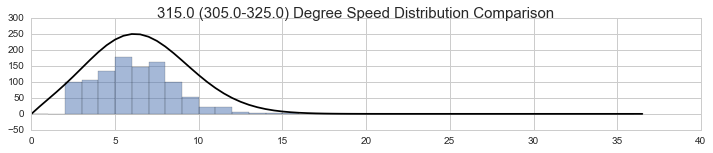

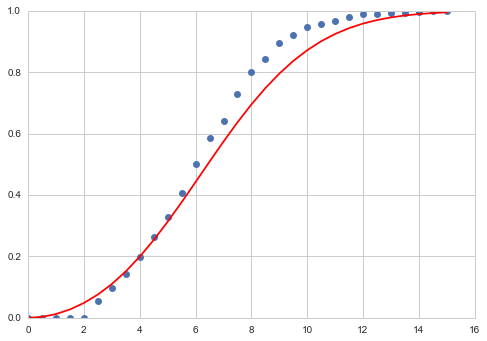

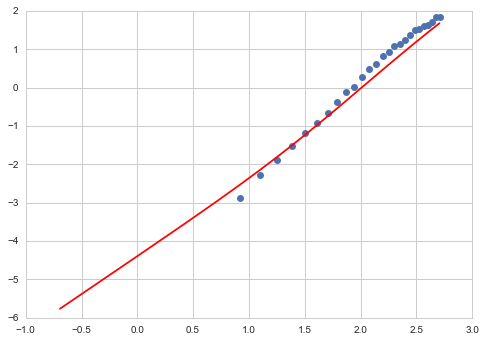

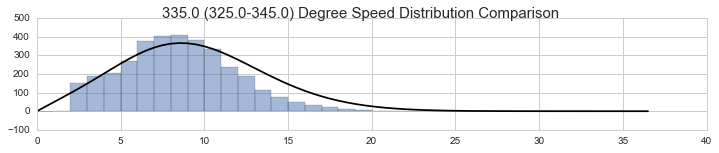

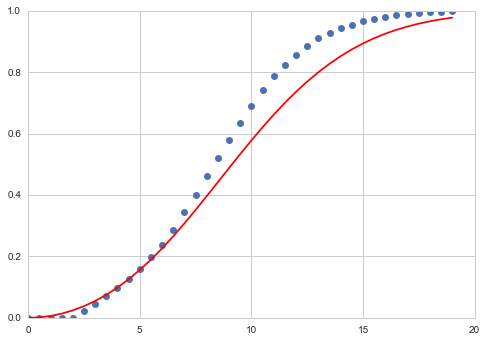

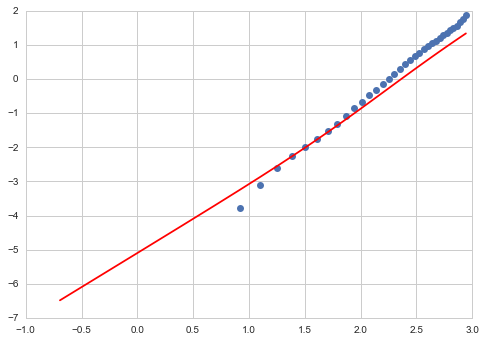

In [60]:
if cn_database:
    model_data_comparison(df, 22.5, 22.5)
else: 
    model_data_comparison(df, 10, 20)

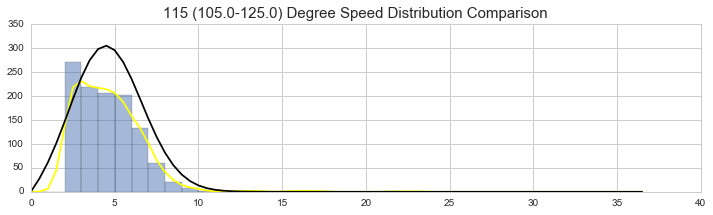

In [61]:
angle =  115
incre = 20

angle_radian, incre_radian = radians(angle), radians(incre)  
x_vals = np.arange(0, max_speed, 0.5)

# Select data from observation
start_angle, end_angle = angle-incre/2, angle+incre/2
sub_df= df[(df['dir'] >= start_angle) & (df['dir'] <= end_angle)] 
max_speed = sub_df.speed.max()

# 1. Observation
bins = np.arange(0, max_speed, 1)
sub_df['speed'].hist(bins=bins, alpha=0.5,figsize=(12, 3))

# 2. 1d KDE 
sample = np.array(sub_df.speed).reshape(-1, 1)
sub_kde = neighbors.KernelDensity(bandwidth=0.5).fit(sample) 
y_vals = [np.exp(sub_kde.score_samples(x_val))*len(sample) for x_val in x_vals]
plt.plot(x_vals, y_vals,'-', color='yellow')

# 3. GMM
y_vals_ =[integrate.nquad(f, [[x_val-0.5, x_val+0.5],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) for x_val in x_vals]
y_vals = np.array(zip(*y_vals_)[0])*len(df) 
plt.plot(x_vals, y_vals,'-', color='black')

title = str(angle) + ' (' + str(start_angle) + '-' +str(end_angle) + ')'
plt.suptitle(title+' Degree Speed Distribution Comparison', fontsize = 15)
plt.show()

## Bootstrap, to see the variance of each sector

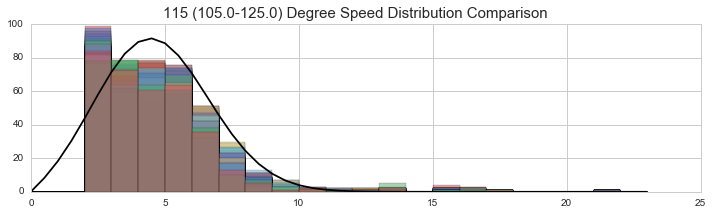

In [62]:
x_vals = np.arange(0, max_speed, 0.5)
y_vals_ =[integrate.nquad(f, [[x_val-0.5, x_val+0.5],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) for x_val in x_vals]
y_vals = np.array(zip(*y_vals_)[0])*len(df.speed)*0.3
plt.plot(x_vals, y_vals,'-', color='black')

bins = np.arange(0, max_speed, 1)
for i in xrange(1,100):
    sub_df_resampled = sub_df.sample(frac=0.3, replace=True)
    sub_df_resampled['speed'].hist(bins=bins, alpha=0.5,figsize=(12, 3))

title = str(angle) + ' (' + str(start_angle) + '-' +str(end_angle) + ')'
plt.suptitle(title+' Degree Speed Distribution Comparison', fontsize = 15)

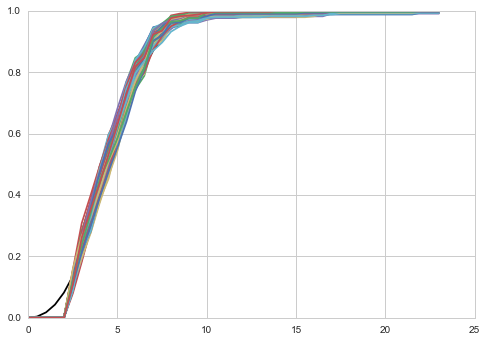

In [63]:
x = np.arange(0, max_speed, 0.5)
y_ =[integrate.nquad(f, [[0, x_val],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) for x_val in x]
direction_prob = integrate.nquad(f, [[0, inf],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_gmm = np.array(zip(*y_)[0])/direction_prob[0]
plt.plot(x, y_gmm,'-', color = 'black')
for i in xrange(1,100):
    sub_df_resampled = sub_df.sample(frac=0.3, replace=True)
    
    sample = sub_df_resampled.speed
    ecdf = sm.distributions.ECDF(sample)
    y_cdf = ecdf(x)

    plt.plot(x, y_cdf,'-')

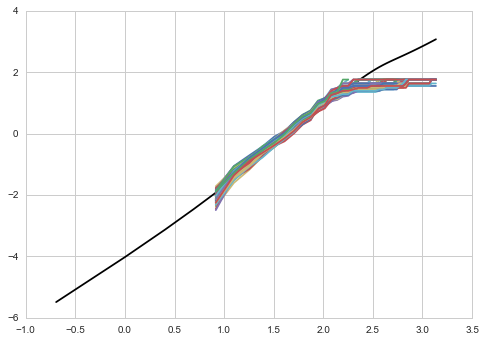

In [64]:
plt.plot(np.log(x), np.log(-np.log(1-y_gmm)),'-', color = 'black')
for i in xrange(1,100):
    sub_df_resampled = sub_df.sample(frac=0.3, replace=True)
    
    sample = sub_df_resampled.speed
    ecdf = sm.distributions.ECDF(sample)
    y_cdf = ecdf(x)

    plt.plot(np.log(x), np.log(-np.log(1-y_cdf)),'-')

# Cross Validation, to check the number of ellipse to be fitted

In [ ]:
from sklearn.cross_validation import train_test_split, KFold
    
def fit_gmm(df, number_of_gaussian = 3, fit_method = 'square_error', print_result = False):
    # 1. Create Input, speed_set
    sample = sub_speed_set = np.array(zip(df.x, df.y))
    points = fitting_range
    
    # 2. KDE + EM fitting
    kde = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample) 
    kde_result = np.exp(kde.score_samples(points))

    clf = mixture.GMM(n_components=number_of_gaussian, covariance_type='full')
    clf.fit(sample)
    gmm_em_result = read_gmm_em_result(clf, print_result)
        
    # 3. GMM fitting
    x0 = gmm_em_result
    bonds = [(0., 0.99),(-30, 30),(-30, 30),(0., 30),(0., 30),(-0.99, 0.99)]*int(len(x0)/6)
    cons = [{'type': 'eq', 'fun': lambda x: sum(x[::6]) - 1},]
 
    result = sp.optimize.minimize(
        lambda x0: GMM_fit_score(x0, kde_result, method=fit_method),
        x0,
        bounds = bonds,
        constraints = cons,
        tol = 0.000000000001,
        options = {"maxiter": 500})  
    
    # 4. Returns
    gmm = group_gmm_param_from_gmm_param_array(result.x)       
    mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
    gmm_pdf_result = mixed_model_pdf(points)
    
    return {
        'gmm' : gmm,
        'kde_result': kde_result,
        'gmm_pdf_result': gmm_pdf_result,
        'number_of_iteration': result.nit}

In [ ]:
## 5-fold cross validation
CV_result_all =[]
print 'Number of train/test dataset', len(df)*4/5, len(df)/5

for number_of_gaussian in xrange(1,6):
    print '  '
    print 'Number of gaussian', number_of_gaussian
    
    kf = KFold(len(df), n_folds=5, shuffle=True) # each number of gaussian, fit 4 times

    CV_result = []
    for train_index, test_index in kf:
        sub_df = df.iloc[train_index]
        sub_df_test = df.iloc[test_index]

        # 1. Train
        result = fit_gmm(sub_df, number_of_gaussian, fit_method = 'square_error')
        gmm_pdf_result_train = result['gmm_pdf_result']

        # 2. Validate
        # GMM from Train - KDE from Test
        sample = np.array(zip(sub_df_test.x, sub_df_test.y))
        kde_test = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample) 
        kde_result_test = np.exp(kde_test.score_samples(points))

        gof_train = goodness_of_fit_summary(gmm_pdf_result_train, 
                                            kde_result, 
                                            count = len(sub_df))
        gof_test =  goodness_of_fit_summary(gmm_pdf_result_train, 
                                            kde_result_test, 
                                            count = len(sub_df_test))
        
        display(pd.DataFrame([gof_train, gof_test], index=["gof_train", "gof_test"]))
        
        CV_result.append(gof_test)
        
    CV_result_all.append(CV_result)

Number of train/test dataset 58384.0 14596.0
  
Number of gaussian 1


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,21131.760212,0.058231,1.496766e-07,0.067777,0.688271,0.865366
gof_test,5383.231251,0.060356,1.595719e-07,0.067332,0.711112,0.856984


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,21063.880829,0.05776,1.495144e-07,0.067740,0.687898,0.865512
gof_test,9474.369104,0.05936,1.500051e-07,0.069279,0.688927,0.863676


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,20862.146189,0.057929,1.492133e-07,0.067672,0.687205,0.865783
gof_test,6395.217976,0.054969,1.420651e-07,0.065395,0.670980,0.871716


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,20753.887618,0.057506,1.491607e-07,0.067660,0.687084,0.865830
gof_test,11316.850324,0.056744,1.531386e-07,0.066104,0.696582,0.862771


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,21471.166409,0.058427,1.500320e-07,0.067857,0.689088,0.865047
gof_test,4590.918750,0.058425,1.554314e-07,0.065776,0.700175,0.862653


  
Number of gaussian 2


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,5198579.690468,0.014006,3.317926e-08,0.031911,0.324053,0.970155
gof_test,9882234.956526,0.013237,3.742486e-08,0.033503,0.344956,0.965752


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,5780641.163883,0.014418,3.317894e-08,0.031911,0.324051,0.970156
gof_test,269709.412671,0.014939,3.489763e-08,0.032165,0.332460,0.968324


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,6918507.351154,0.014979,3.320232e-08,0.031922,0.324165,0.970135
gof_test,1123705.190533,0.017140,3.885925e-08,0.033213,0.351041,0.965855


In [ ]:
for idx, gof_group in enumerate(CV_result_all):
    print 'number of gaussian', idx+1
    display(pd.DataFrame(gof_group))

In [ ]:
mean_gof_all = []
for idx, gof_group in enumerate(CV_result_all):
    mean_gof = np.mean(pd.DataFrame(gof_group))
    mean_gof_all.append(mean_gof)
mean_gof_all = pd.DataFrame(mean_gof_all)
mean_gof_all

In [ ]:
x = [1,2,3,4,5]
for column in ['R_square','Chi_square', 'K_S']:
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 3)
    plt.plot(x, mean_gof_all[column],'-')
    plt.suptitle(column)
    plt.show()